In [1]:
import pandas as pd
import os

# Load historical data
data_dir = "../data"
symbols = [f.split('_')[0] for f in os.listdir(data_dir) if f.endswith('_historical.csv')]

# Function to load data for a symbol
def load_data(symbol):
    return pd.read_csv(f"{data_dir}/{symbol}_historical.csv")

# Combine closing prices into a single DataFrame
prices = pd.DataFrame()
for symbol in symbols:
    df = load_data(symbol)
    df['open_time'] = pd.to_datetime(df['open_time'])
    prices[symbol] = df.set_index('open_time')['close']

# Handle missing data by forward filling
prices.ffill(inplace=True)

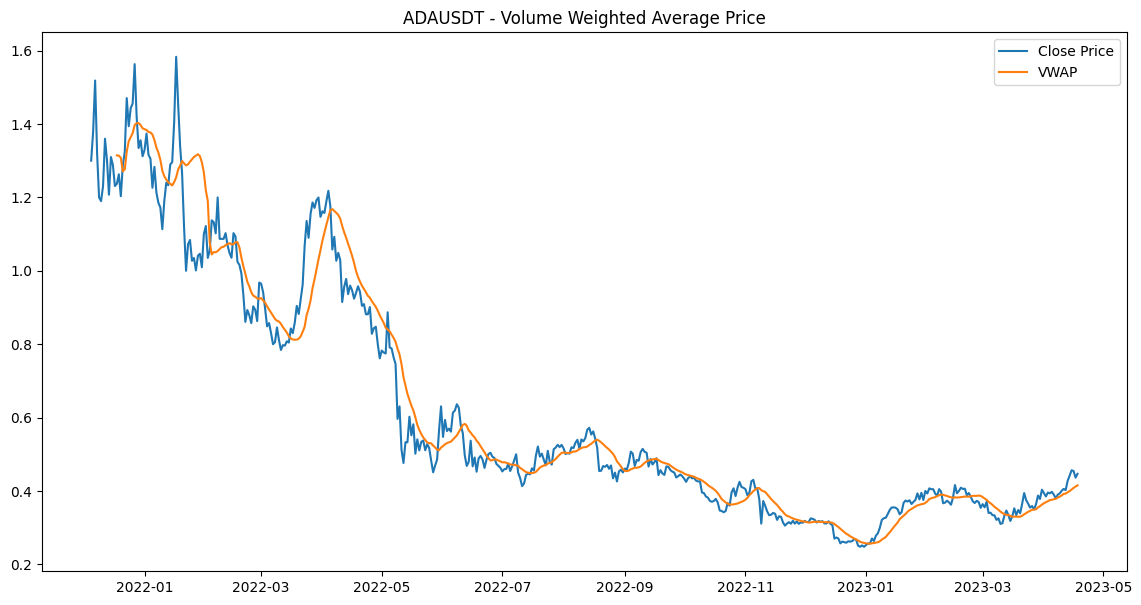

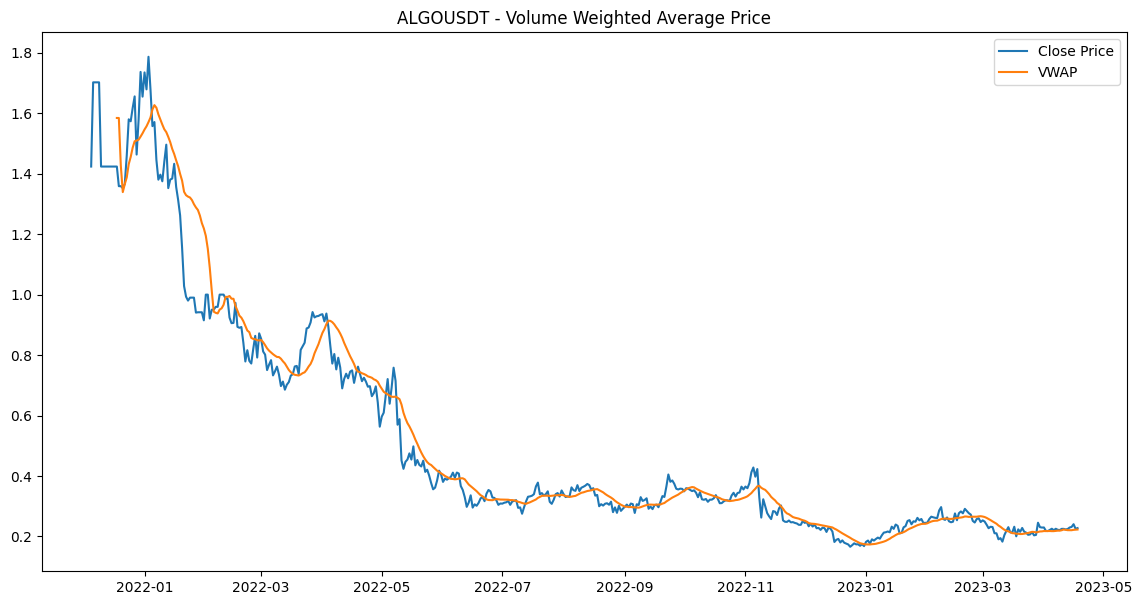

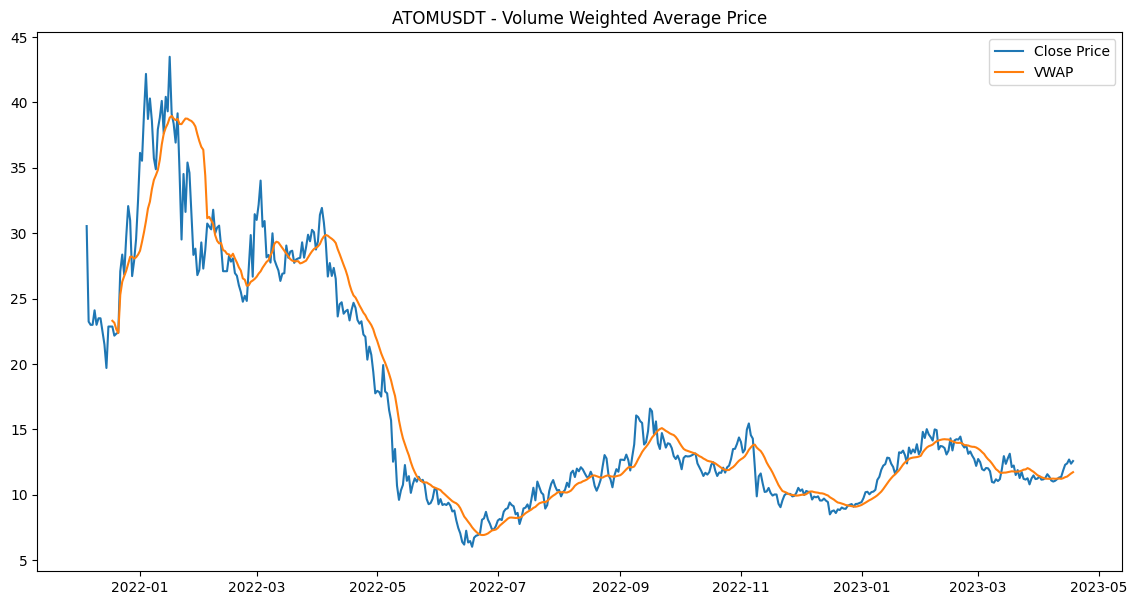

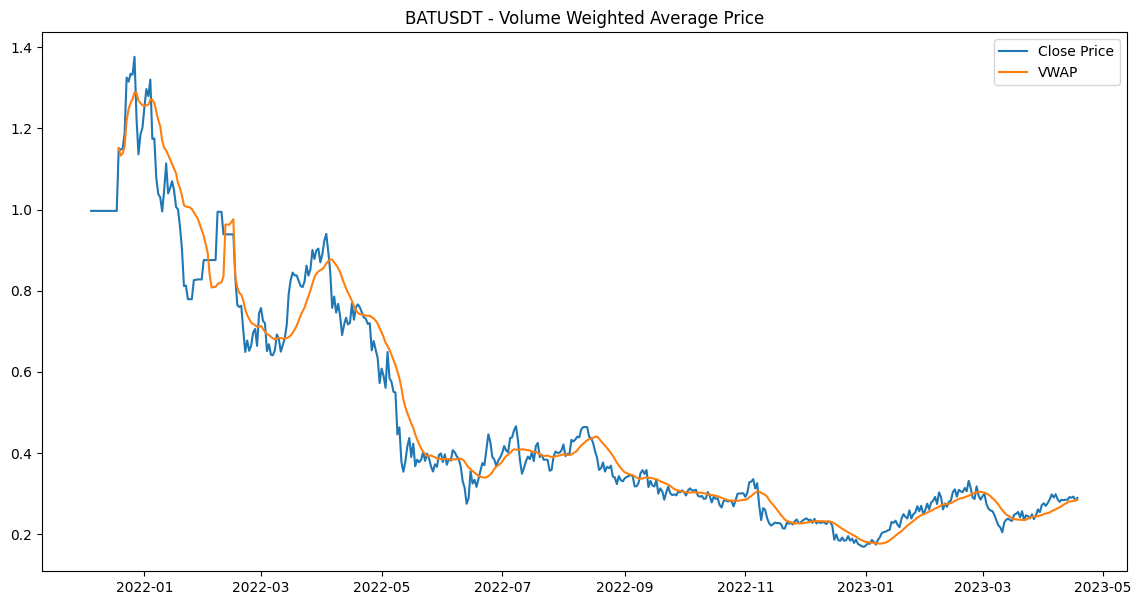

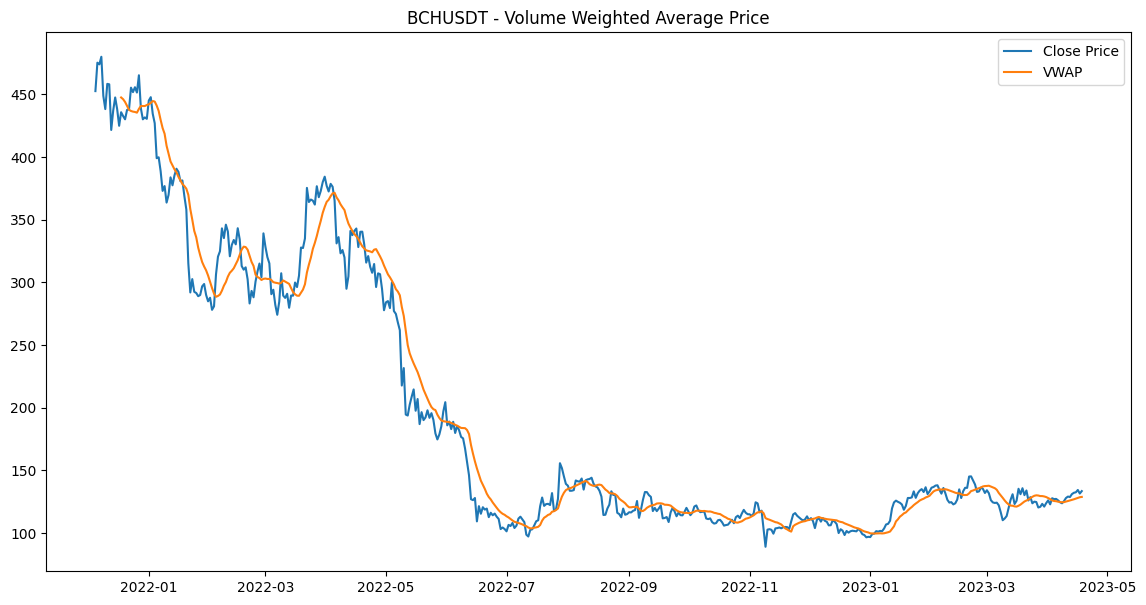

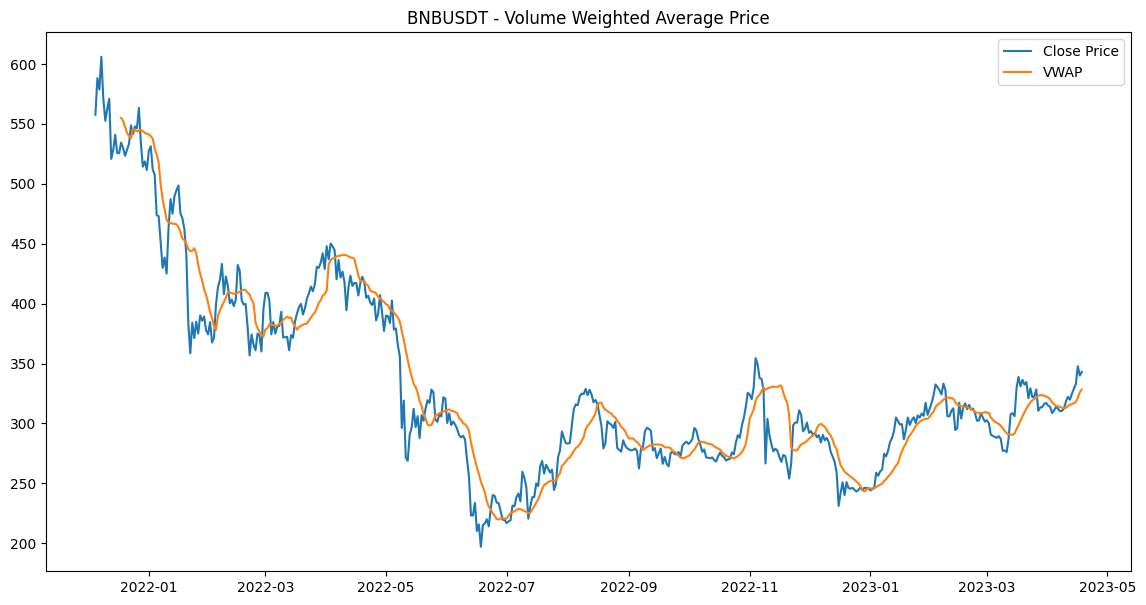

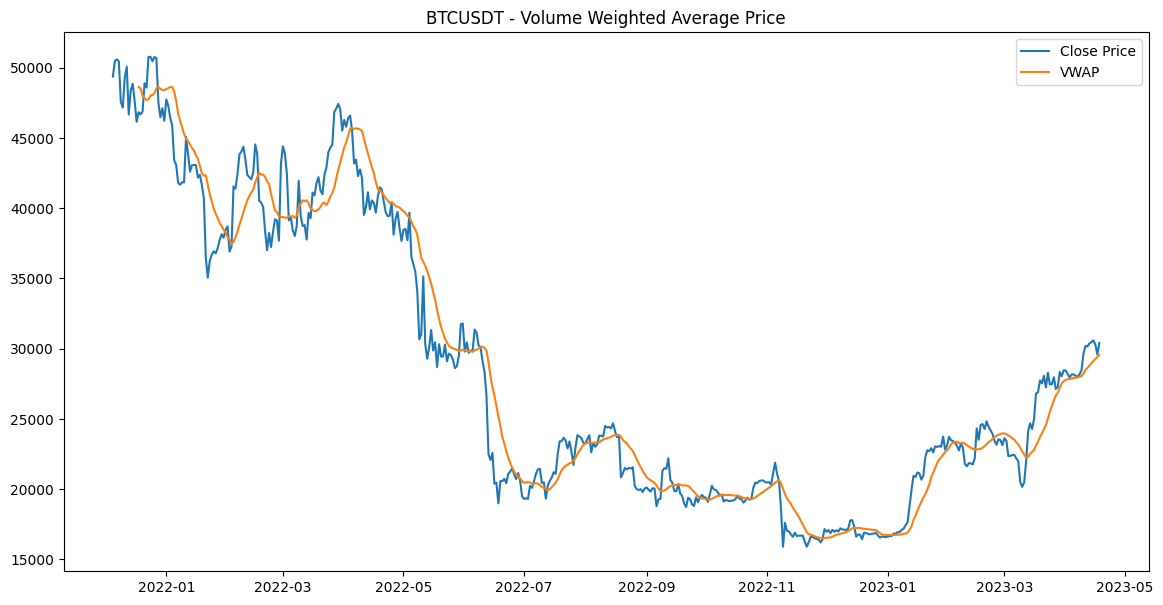

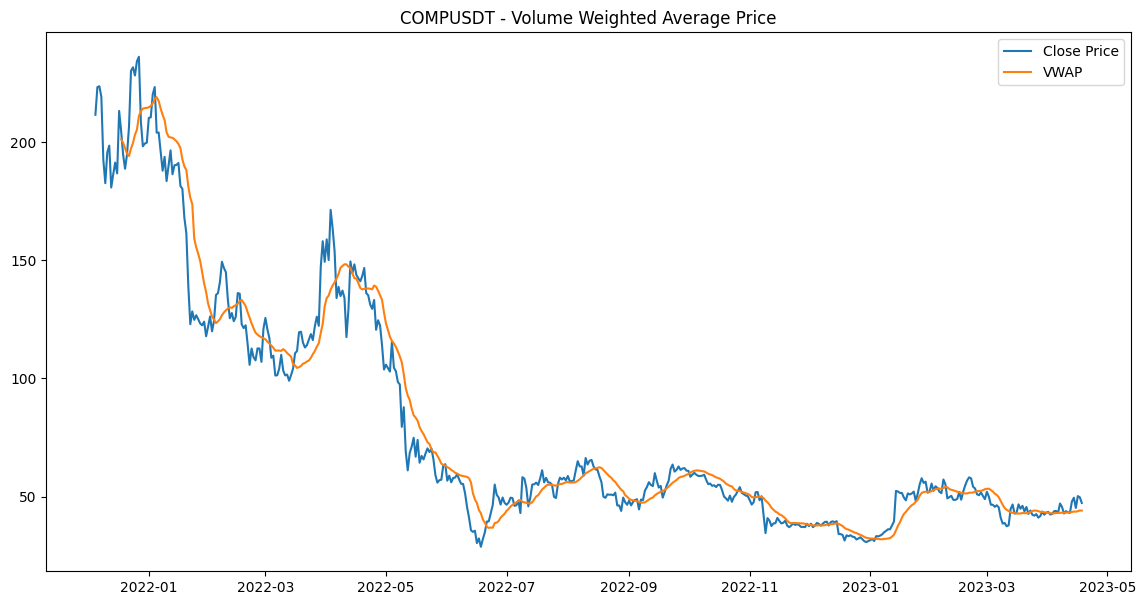

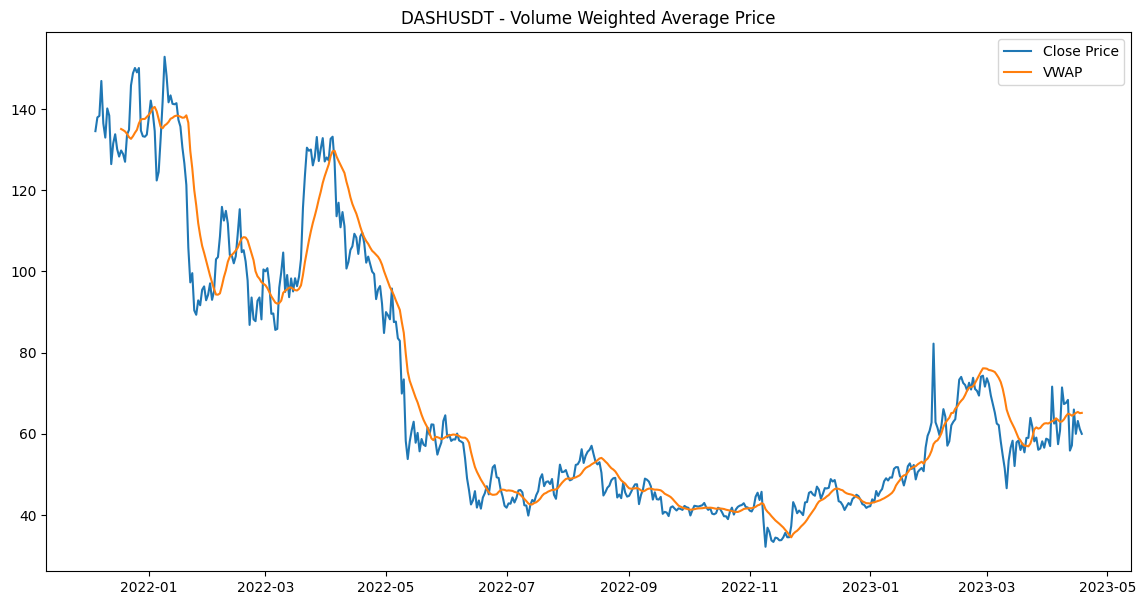

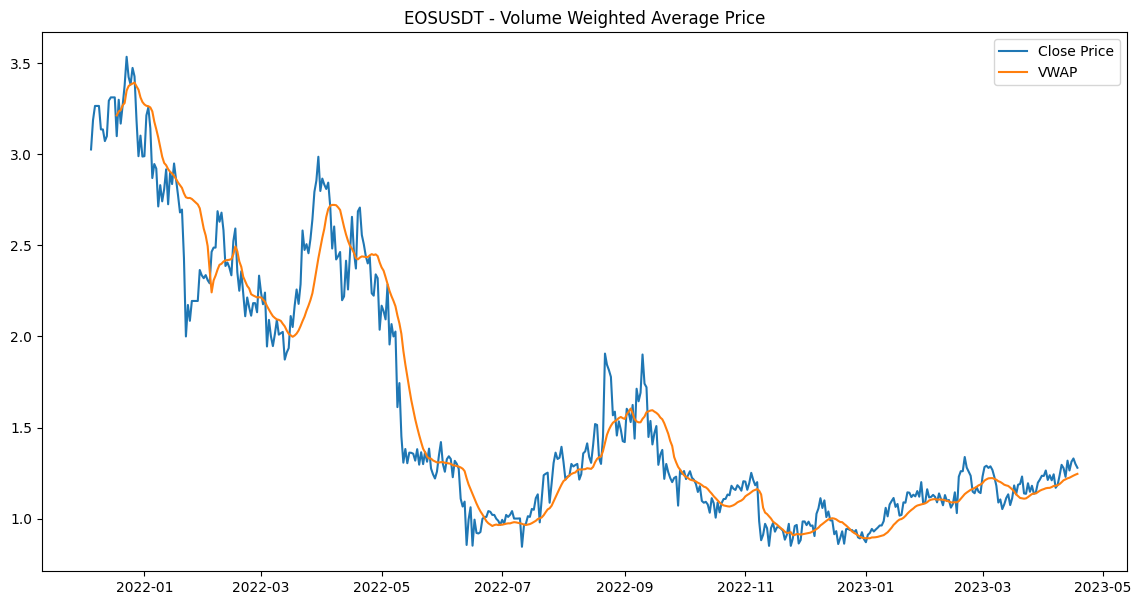

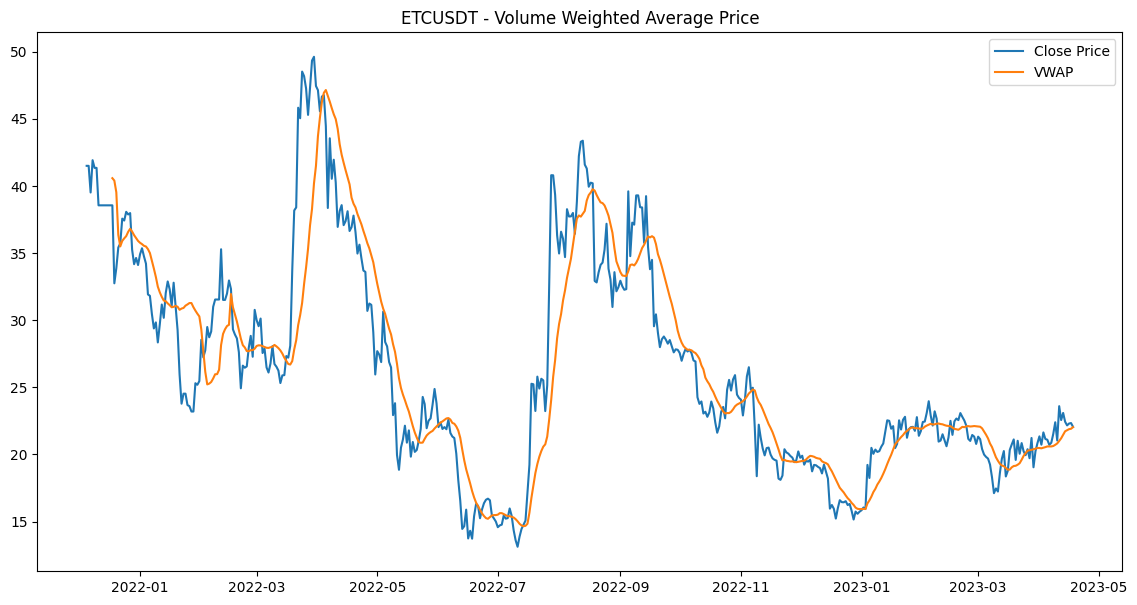

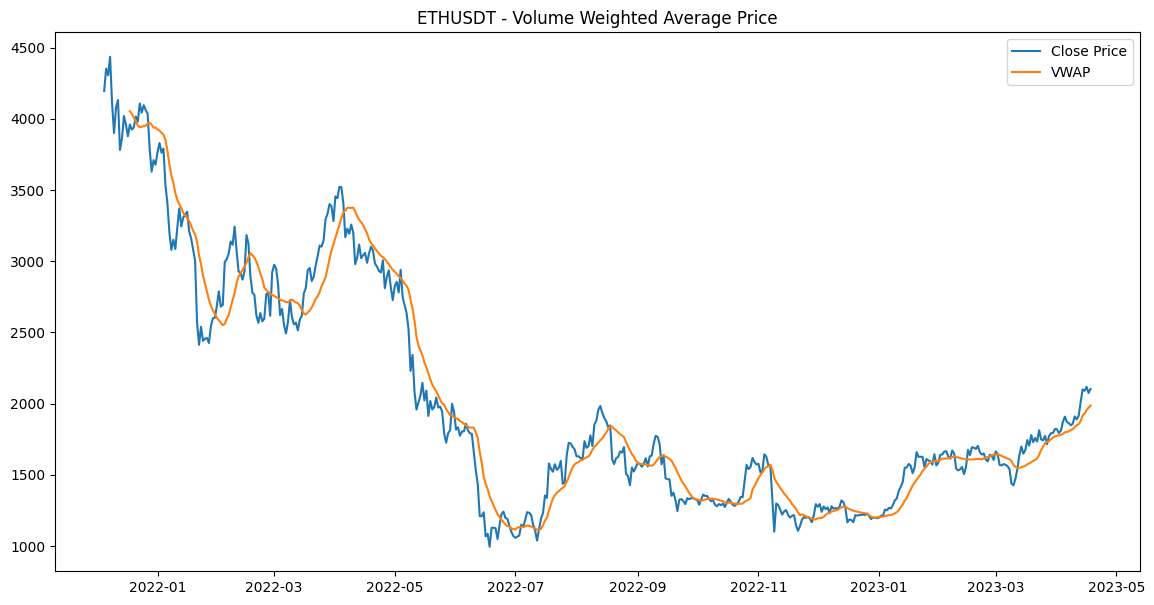

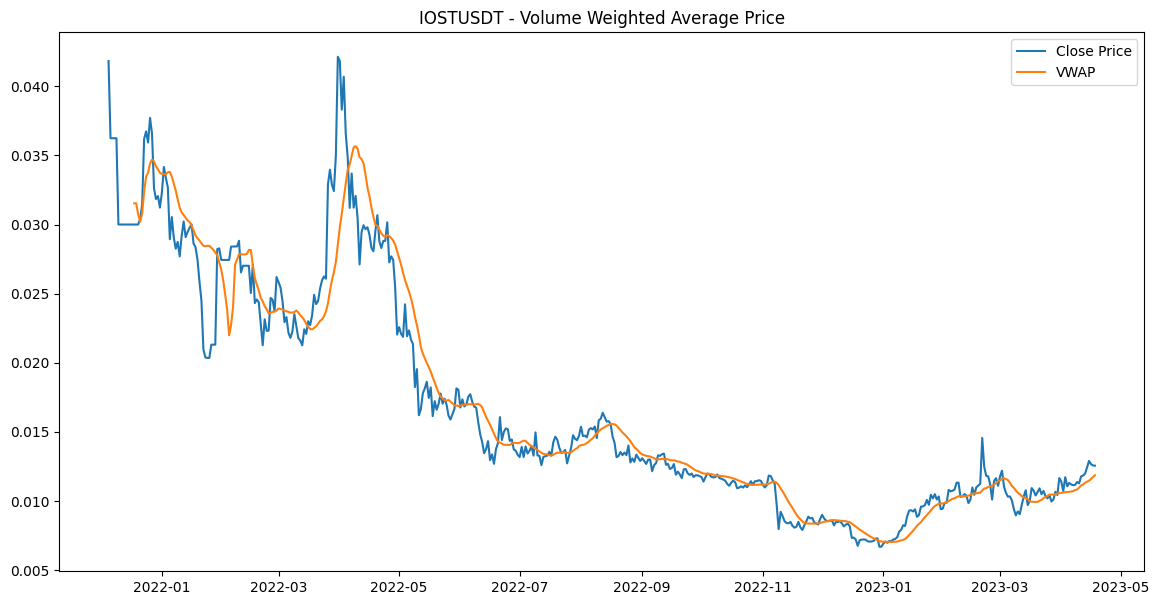

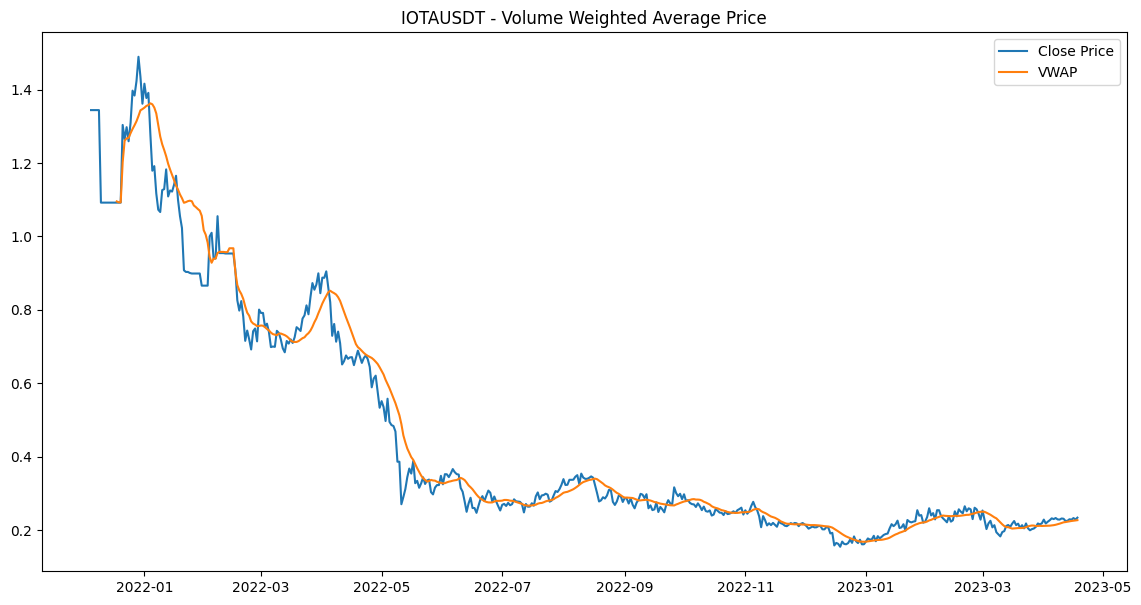

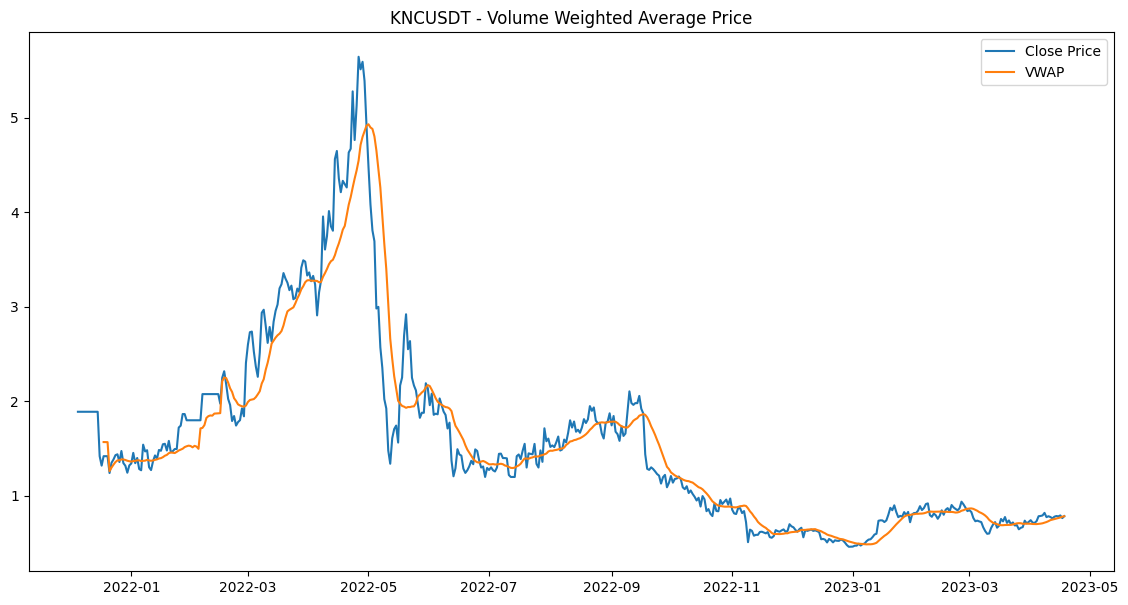

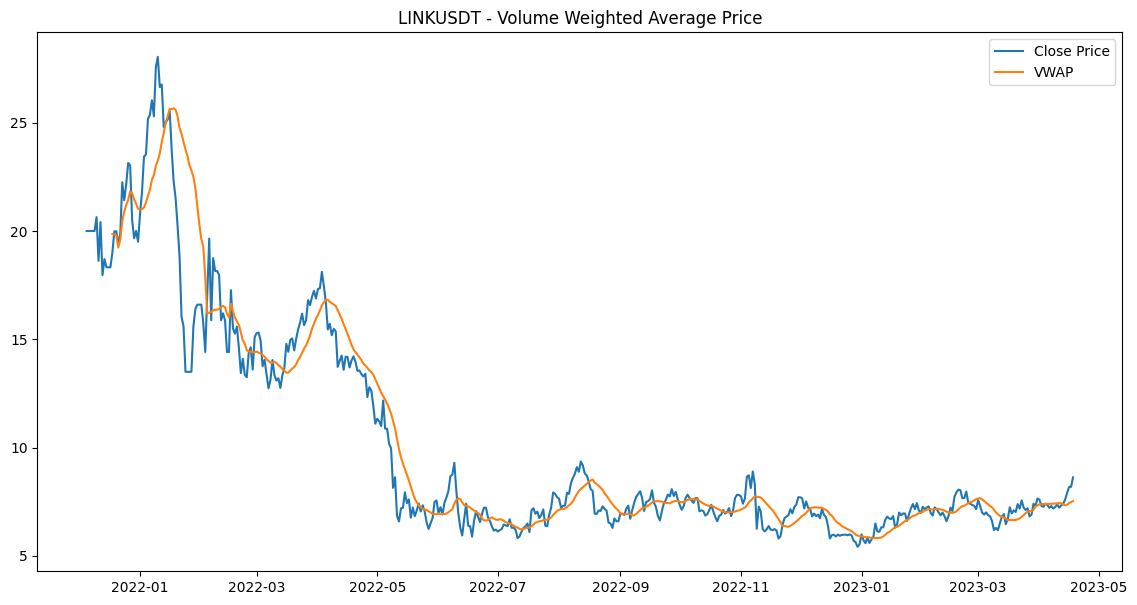

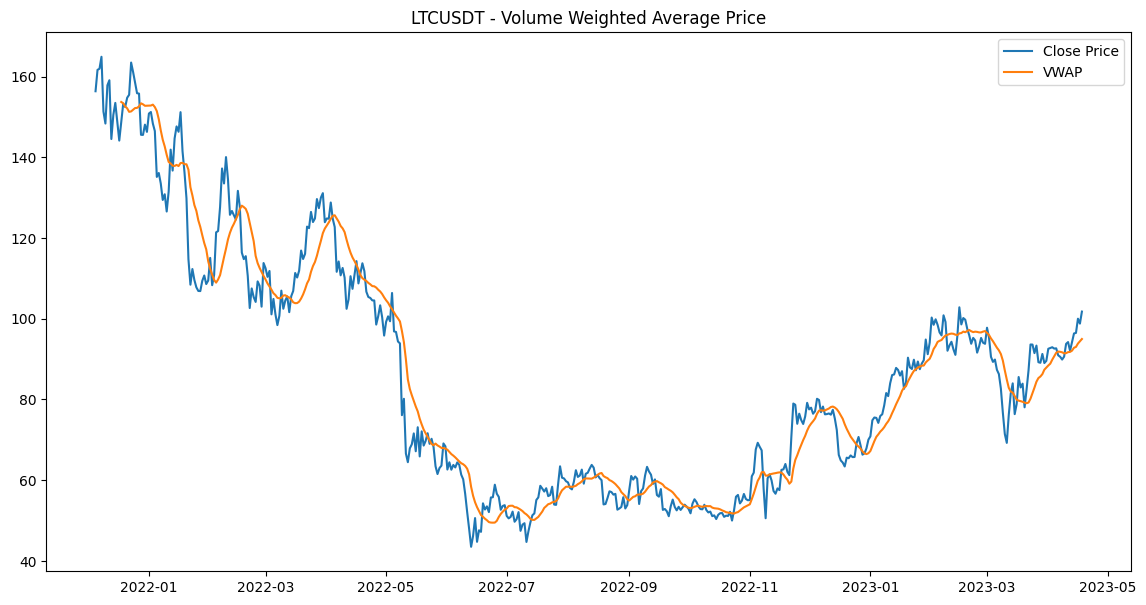

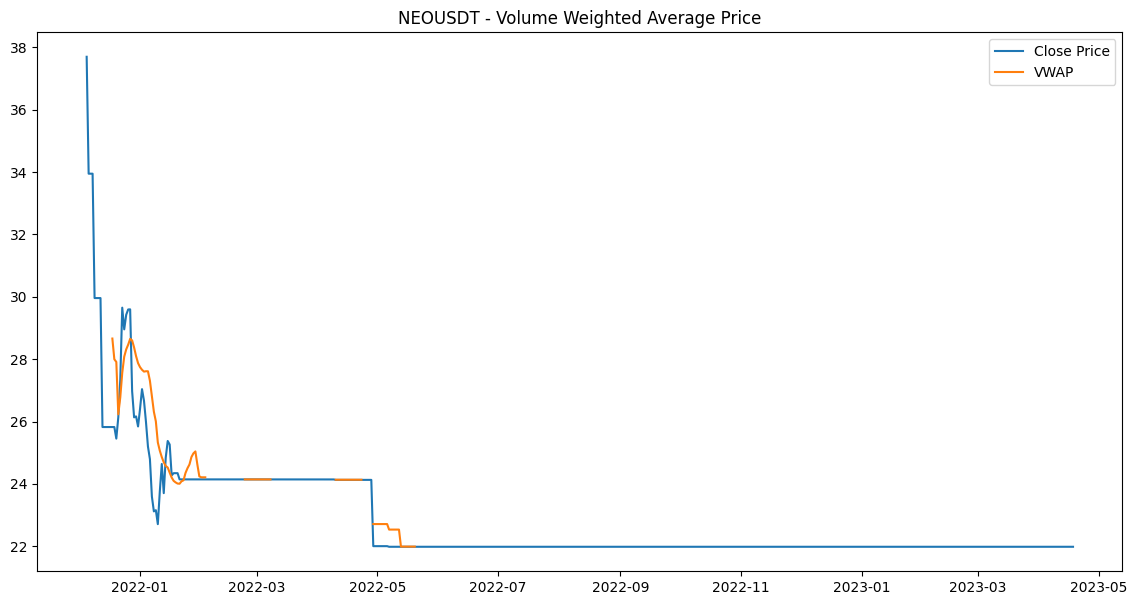

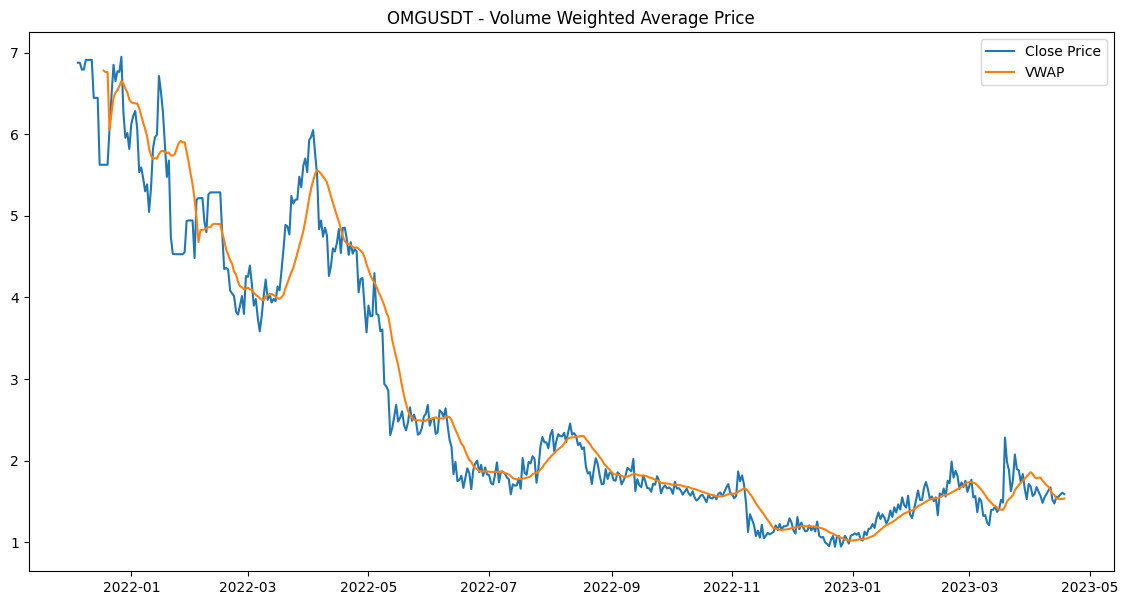

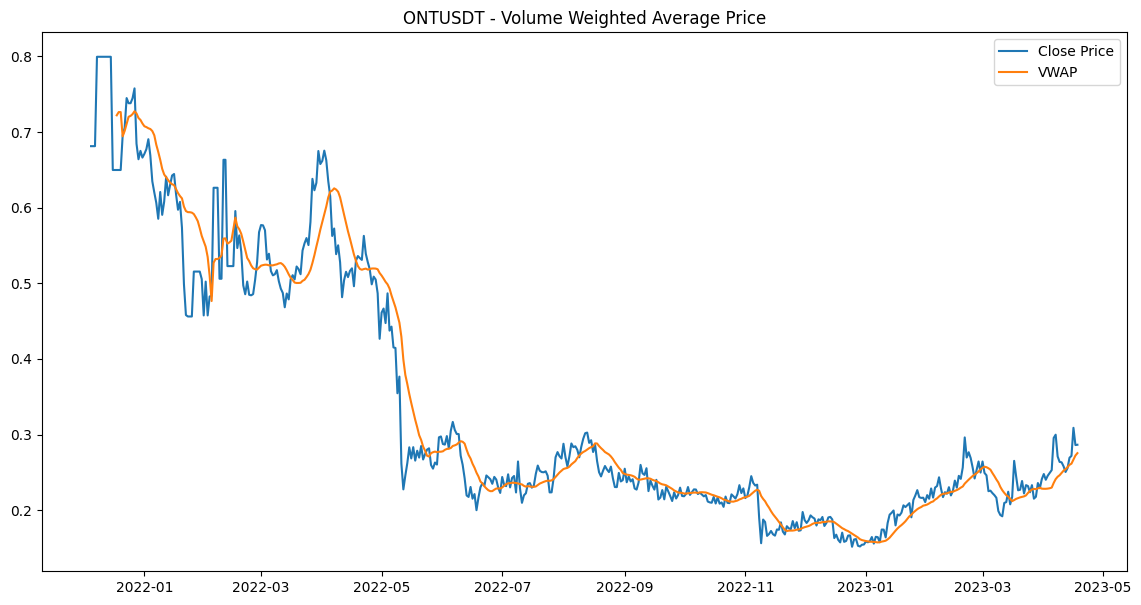

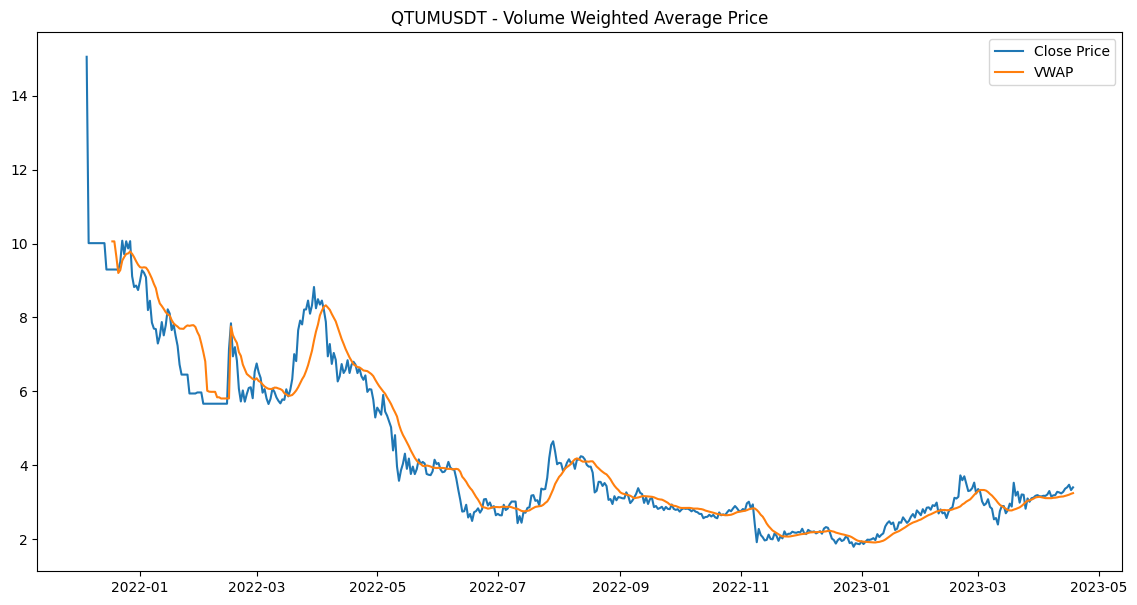

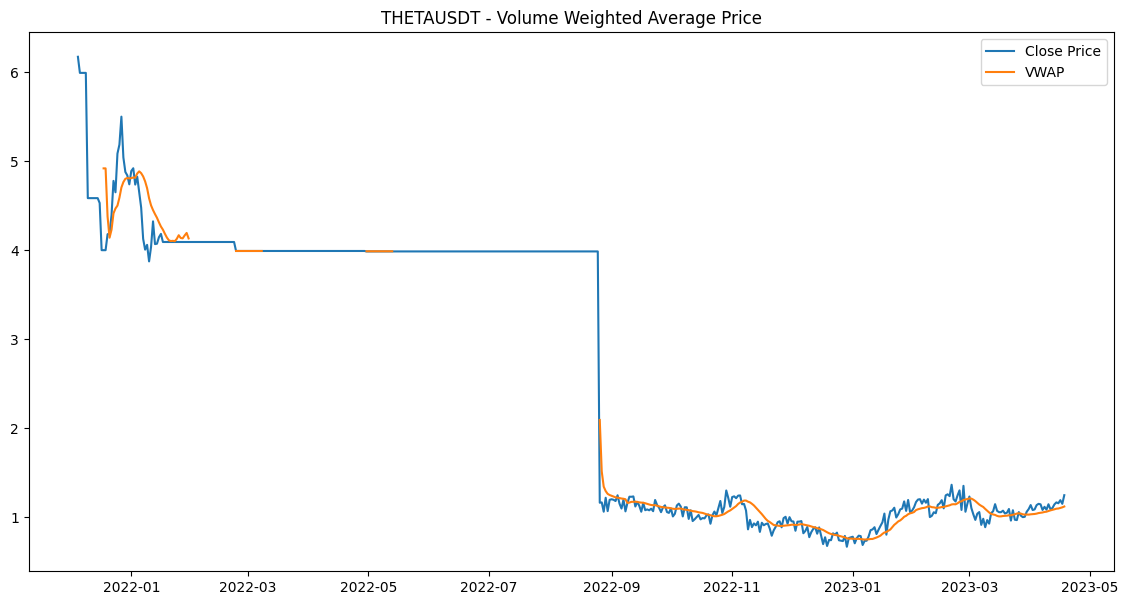

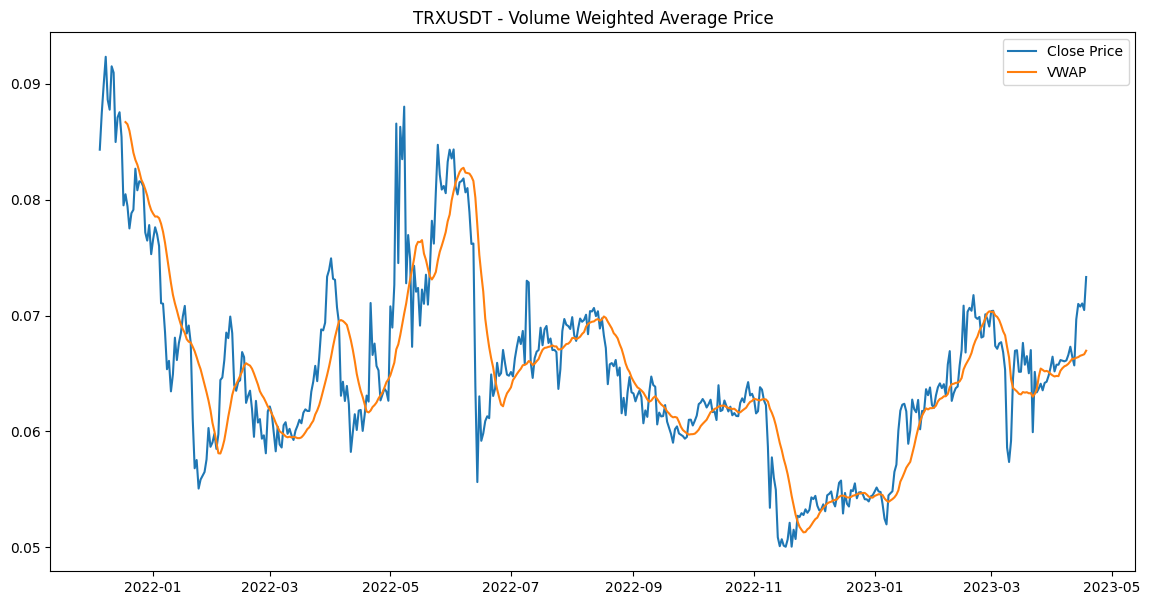

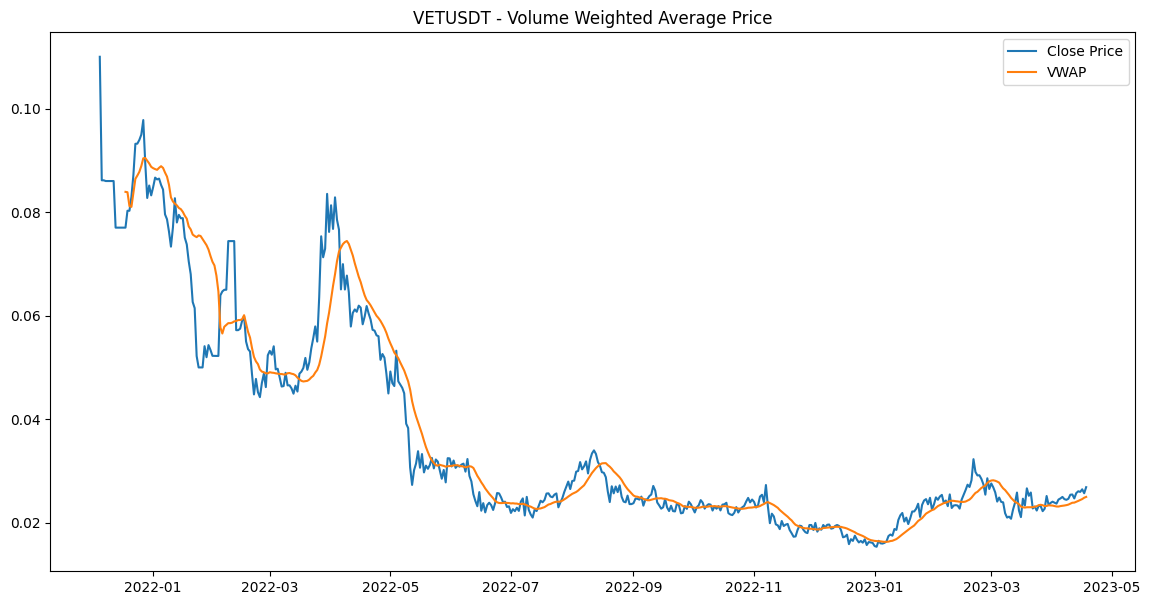

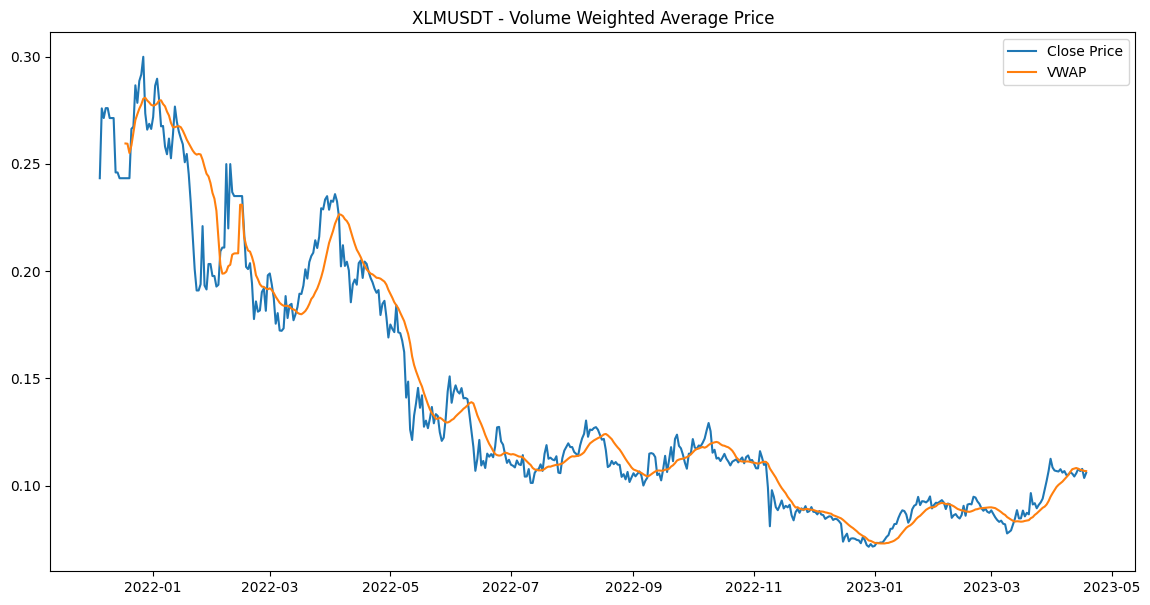

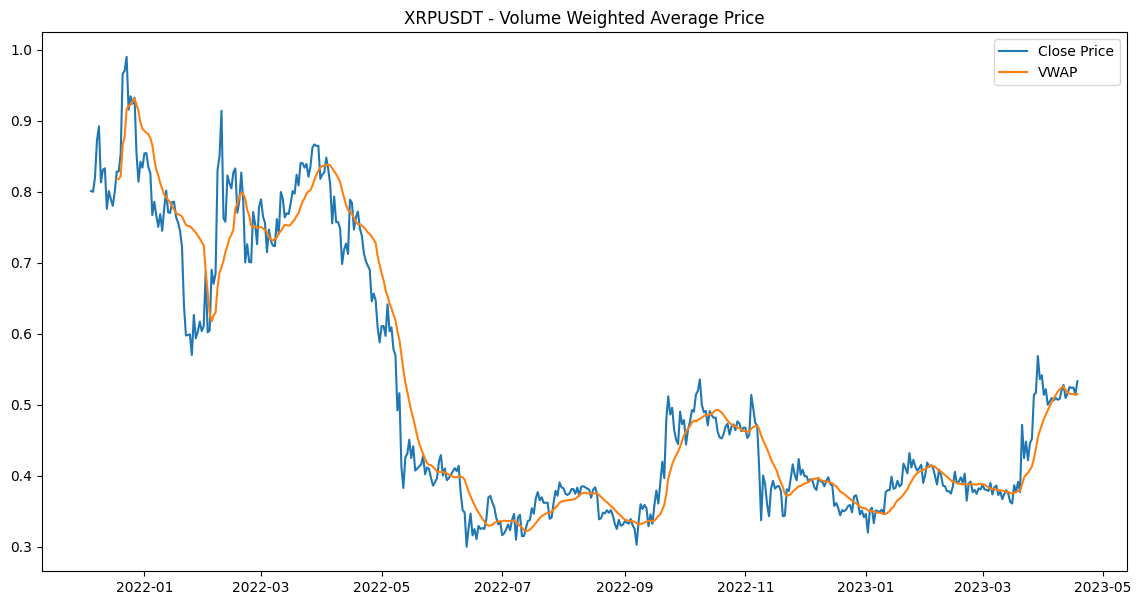

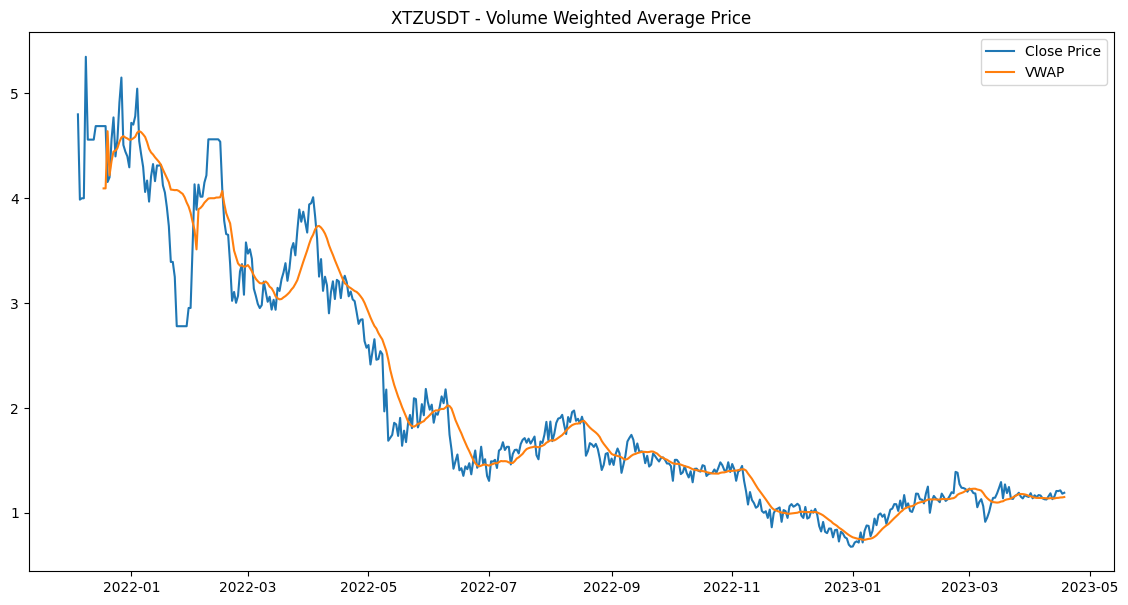

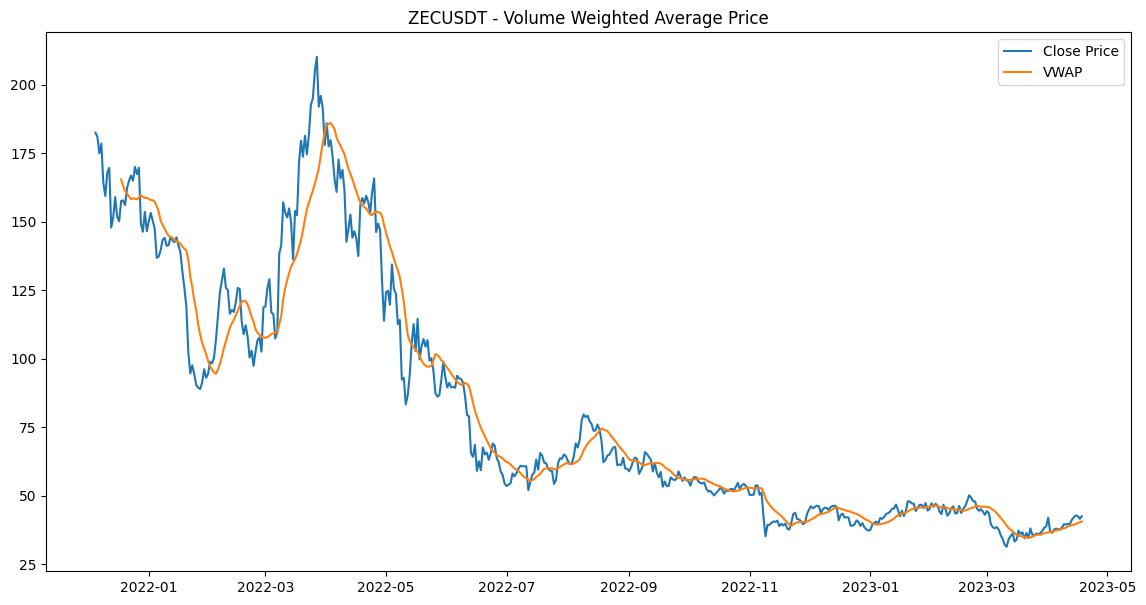

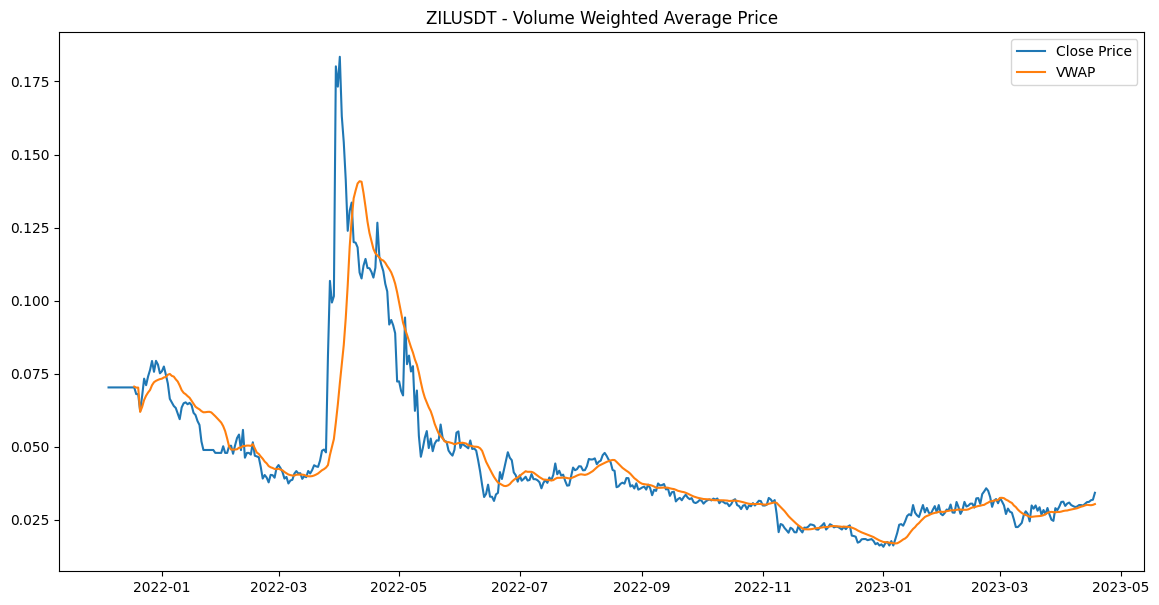

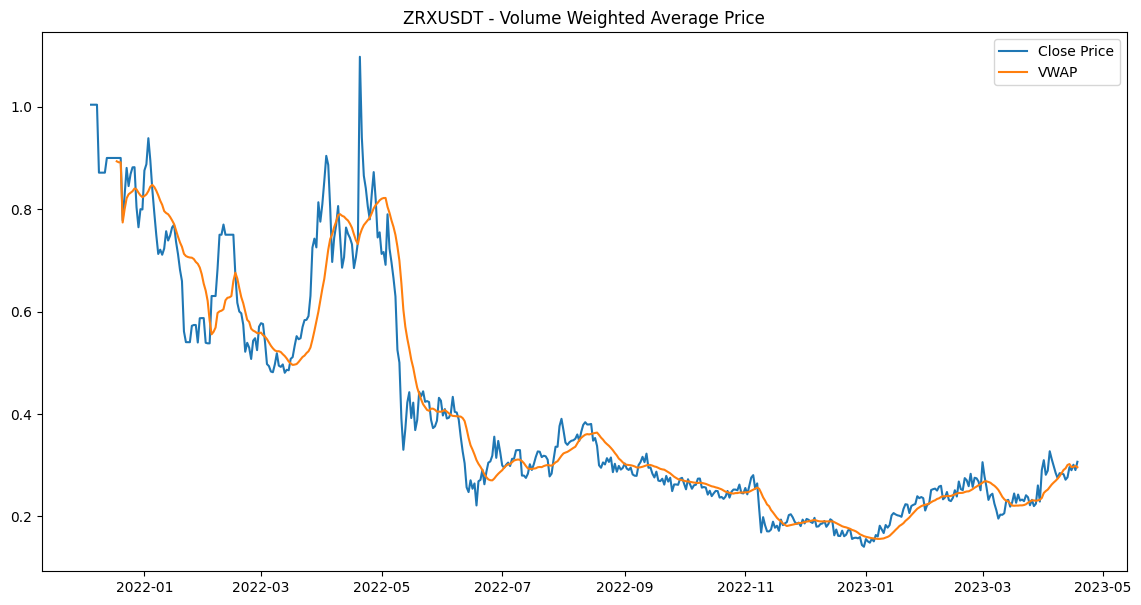

In [2]:
import ta
import matplotlib.pyplot as plt

# Volume-based Indicator: Volume Weighted Average Price (VWAP)
for symbol in symbols:
    df = load_data(symbol)
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.set_index('open_time', inplace=True)
    df['VWAP'] = ta.volume.volume_weighted_average_price(df['high'], df['low'], df['close'], df['volume'])
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['close'], label='Close Price')
    plt.plot(df.index, df['VWAP'], label='VWAP')
    plt.title(f'{symbol} - Volume Weighted Average Price')
    plt.legend()
    plt.show()

# Repeat similar steps for other categories of indicators

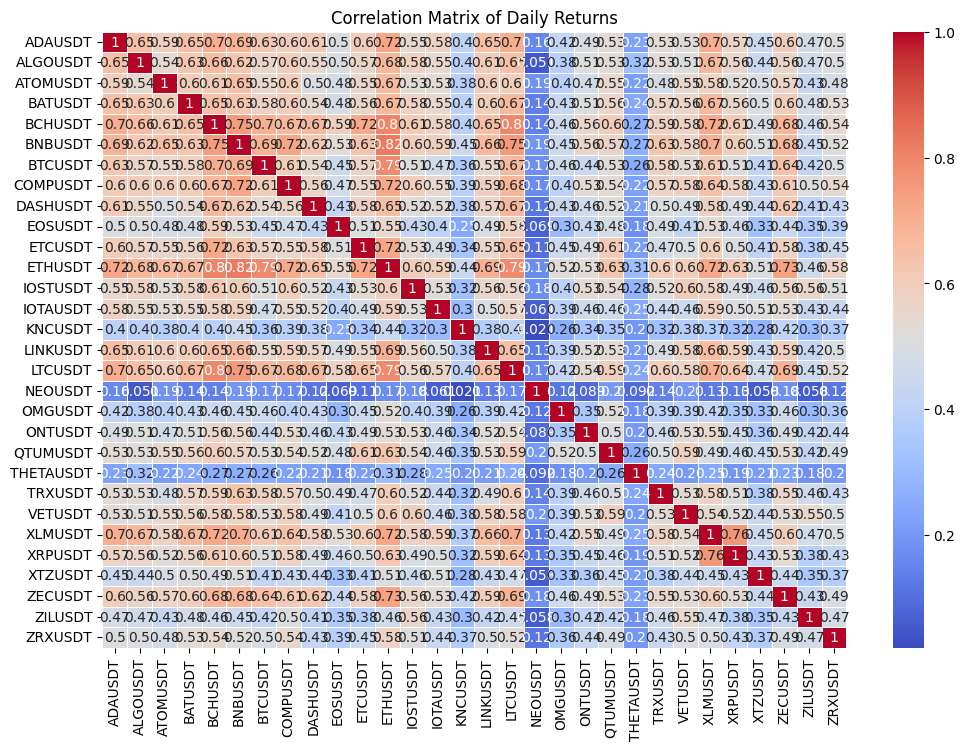

In [3]:
import seaborn as sns

# Calculate daily returns
returns = prices.pct_change().dropna()

# Calculate correlations
correlations = returns.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Daily Returns')
plt.show()

In [13]:
# pick out thouse that have a correlation of 0.5 or higher and plot them removing the diagonal as well as the inv
highly_correlated = correlations[correlations > 0.5]
highly_correlated = highly_correlated.stack().reset_index()
highly_correlated = highly_correlated[highly_correlated['level_0'] != highly_correlated['level_1']]
highly_correlated.columns = ['Symbol 1', 'Symbol 2', 'Correlation']

# give me the top 10
top_correlations = highly_correlated.sort_values('Correlation', ascending=False).head(10)
print(top_correlations)


    Symbol 1 Symbol 2  Correlation
124  BNBUSDT  ETHUSDT     0.821388
232  ETHUSDT  BNBUSDT     0.821388
231  ETHUSDT  BCHUSDT     0.801666
100  BCHUSDT  ETHUSDT     0.801666
317  LTCUSDT  BCHUSDT     0.795743
104  BCHUSDT  LTCUSDT     0.795743
148  BTCUSDT  ETHUSDT     0.792519
233  ETHUSDT  BTCUSDT     0.792519
242  ETHUSDT  LTCUSDT     0.790003
324  LTCUSDT  ETHUSDT     0.790003


In [26]:
import backtrader as bt
import pandas as pd
import os

# Function to load data for a symbol
def load_data(symbol):
    data_dir = "../data"
    file_path = f"{data_dir}/{symbol}USDT_historical.csv"
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        print(f"File not found: {file_path}")
        return None

# Define a simple strategy
class SimpleMovingAverageStrategy(bt.Strategy):
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=15)

    def next(self):
        if self.data.close > self.sma:
            self.buy()
        elif self.data.close < self.sma:
            self.sell()

# Load data into Backtrader
btc_data = load_data('BTC')
if btc_data is not None:
    btc_data['open_time'] = pd.to_datetime(btc_data['open_time'])
    btc_data.set_index('open_time', inplace=True)
    data = bt.feeds.PandasData(dataname=btc_data)

    # Initialize Cerebro engine
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SimpleMovingAverageStrategy)
    cerebro.adddata(data)
    cerebro.broker.set_cash(10000)
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

    # Run backtest
    results = cerebro.run()

    # Plot results
    cerebro.plot()

    # Extract and print performance metrics
    returns_dict = results[0].analyzers.returns.get_analysis()
    print("Performance Metrics:")
    print(f"Total Return: {returns_dict['rtot']:.2%}")
    print(f"Annualized Return: {returns_dict['rnorm']:.2%}")
    print(f"Annualized Volatility: {returns_dict['rnorm100']:.2%}")
else:
    print("BTC data not available for backtesting.")

<IPython.core.display.Javascript object>

Performance Metrics:
Total Return: 421.02%
Annualized Return: 734.73%
Annualized Volatility: 73473.38%
